<a href="https://colab.research.google.com/github/sartaj-sb/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saliency and Grad-CAM Examples

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb)

Import a trained model (.zip file) from Edge Impulse and copy in post-processed features of a single sample image. Run the notebook to see a saliency map and Grad-CAM heatmap.

Saliency maps highlight which pixels in the input image were most important (i.e. most salient) in the decision making process.

Grad-CAM looks at the output feature map of the final convolution layer to figure out which areas of the image were the most important in the decision making process.

Author: EdgeImpulse, Inc.<br>
Date: June 19, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [1]:
import numpy as np

import tensorflow as tf
from keras import activations, layers, models, backend

import cv2

import matplotlib.pyplot as plt

In [2]:
### Unzip model

# Change this based on your .zip model filename
model_zip_path = "/content/ei-cnn-classifier-tensorflow-savedmodel-model.zip"

# Unzip in place
!unzip "{model_zip_path}"

Archive:  /content/ei-cnn-classifier-tensorflow-savedmodel-model.zip
   creating: saved_model/
   creating: saved_model/assets/
   creating: saved_model/variables/
  inflating: saved_model/fingerprint.pb  
  inflating: saved_model/saved_model.pb  
  inflating: saved_model/keras_metadata.pb  
  inflating: saved_model/variables/variables.data-00000-of-00001  
  inflating: saved_model/variables/variables.index  


In [12]:
### Settings

# Image resolution
width = 28
height = 28

# Labels
labels = ["background", "bud", "pin", "sdcard"]

# Paste ground processed features from Edge Impulse and set ground-truth label
img = [
0.8049, 0.7753, 0.7552, 0.7575, 0.7575, 0.7737, 0.7658, 0.7525, 0.7508, 0.7474, 0.7541, 0.7529, 0.7462, 0.7419, 0.7407, 0.7395, 0.7391, 0.7372, 0.7368, 0.7312, 0.7262, 0.7266, 0.7250, 0.7238, 0.7238, 0.7246, 0.7234, 0.7206, 0.7979, 0.7670, 0.7630, 0.7619, 0.7654, 0.7795, 0.7755, 0.7580, 0.7529, 0.7525, 0.7525, 0.7501, 0.7446, 0.7446, 0.7446, 0.7434, 0.7411, 0.7372, 0.7345, 0.7305, 0.7294, 0.7294, 0.7285, 0.7277, 0.7277, 0.7289, 0.7277, 0.7250, 0.7686, 0.7704, 0.7670, 0.7681, 0.7658, 0.7642, 0.7658, 0.7615, 0.7559, 0.7536, 0.7548, 0.7532, 0.7470, 0.7462, 0.7446, 0.7419, 0.7411, 0.7419, 0.7333, 0.7294, 0.7328, 0.7294, 0.7266, 0.7285, 0.7266, 0.7266, 0.7262, 0.7227, 0.7811, 0.7772, 0.7732, 0.7732, 0.7689, 0.7642, 0.7607, 0.7591, 0.7598, 0.7564, 0.7525, 0.7536, 0.7536, 0.7497, 0.7481, 0.7451, 0.7423, 0.7423, 0.7372, 0.7317, 0.7328, 0.7328, 0.7317, 0.7277, 0.7277, 0.7254, 0.7273, 0.7238, 0.7896, 0.7862, 0.7806, 0.7744, 0.7693, 0.7665, 0.7615, 0.7615, 0.7580, 0.7541, 0.7541, 0.7575, 0.7575, 0.7520, 0.7508, 0.7451, 0.7428, 0.7423, 0.7368, 0.7345, 0.7328, 0.7305, 0.7294, 0.7294, 0.7266, 0.7266, 0.7250, 0.7220, 0.7952, 0.7873, 0.7834, 0.7772, 0.7716, 0.7681, 0.7658, 0.7603, 0.7580, 0.7548, 0.7564, 0.7568, 0.7552, 0.7536, 0.7490, 0.7493, 0.7485, 0.7411, 0.7395, 0.7368, 0.7328, 0.7333, 0.7271, 0.7294, 0.7285, 0.7266, 0.7254, 0.7250, 0.7963, 0.7889, 0.7811, 0.7764, 0.7748, 0.7716, 0.7670, 0.7665, 0.7607, 0.7598, 0.7564, 0.7564, 0.7545, 0.7564, 0.7525, 0.7501, 0.7485, 0.7384, 0.7372, 0.7407, 0.7411, 0.7277, 0.7305, 0.7271, 0.7289, 0.7254, 0.7250, 0.7250, 0.8007, 0.7951, 0.7889, 0.7889, 0.7834, 0.7760, 0.7721, 0.7693, 0.7642, 0.7603, 0.7568, 0.7564, 0.7564, 0.7559, 0.7548, 0.7525, 0.7446, 0.7368, 0.7402, 0.7238, 0.6001, 0.6858, 0.7384, 0.7259, 0.7289, 0.7250, 0.7238, 0.7215, 0.8175, 0.8051, 0.8007, 0.8093, 0.7979, 0.7760, 0.7732, 0.7732, 0.7693, 0.7642, 0.7575, 0.7559, 0.7559, 0.7525, 0.7525, 0.7525, 0.7407, 0.7368, 0.7407, 0.6636, 0.5702, 0.7273, 0.7310, 0.7254, 0.7250, 0.7250, 0.7215, 0.7199, 0.8367, 0.8101, 0.8011, 0.7917, 0.7838, 0.7760, 0.7725, 0.7698, 0.7693, 0.7638, 0.7606, 0.7520, 0.7536, 0.7536, 0.7525, 0.7485, 0.7372, 0.7379, 0.7102, 0.6216, 0.7151, 0.7204, 0.6869, 0.7128, 0.7238, 0.7215, 0.7211, 0.7188, 0.8501, 0.8371, 0.8062, 0.7912, 0.7834, 0.7776, 0.7737, 0.7670, 0.7681, 0.7615, 0.7559, 0.7629, 0.7606, 0.7501, 0.7564, 0.7451, 0.7372, 0.7298, 0.6338, 0.6983, 0.7035, 0.5710, 0.5979, 0.7105, 0.7215, 0.7211, 0.7199, 0.7176, 0.8466, 0.8427, 0.8062, 0.7873, 0.7822, 0.7772, 0.7732, 0.7681, 0.7619, 0.7568, 0.7564, 0.6920, 0.7191, 0.7649, 0.7455, 0.7345, 0.7540, 0.6451, 0.6909, 0.7062, 0.5343, 0.5199, 0.6766, 0.7199, 0.7199, 0.7204, 0.7199, 0.7172, 0.8670, 0.8559, 0.8007, 0.7850, 0.7795, 0.7725, 0.7681, 0.7654, 0.7596, 0.7522, 0.7751, 0.4822, 0.3418, 0.6997, 0.7423, 0.7937, 0.6522, 0.6659, 0.6968, 0.5175, 0.5153, 0.6821, 0.7183, 0.7199, 0.7192, 0.7204, 0.7204, 0.7160, 0.8720, 0.8490, 0.7944, 0.7834, 0.7767, 0.7721, 0.7663, 0.7642, 0.7619, 0.7522, 0.7698, 0.5604, 0.1246, 0.2867, 0.7763, 0.7424, 0.6361, 0.6709, 0.5066, 0.5165, 0.6815, 0.7188, 0.7183, 0.7211, 0.7215, 0.7211, 0.7176, 0.7160, 0.8434, 0.8168, 0.7882, 0.7845, 0.7772, 0.7704, 0.7681, 0.7642, 0.7561, 0.7480, 0.7711, 0.5361, 0.1398, 0.0793, 0.3170, 0.5979, 0.6730, 0.4856, 0.5162, 0.6826, 0.7137, 0.7153, 0.7153, 0.7176, 0.7176, 0.7176, 0.7155, 0.7172, 0.8203, 0.7983, 0.7933, 0.7815, 0.7709, 0.7693, 0.7642, 0.7573, 0.7476, 0.7702, 0.5770, 0.1859, 0.0949, 0.0946, 0.0655, 0.2588, 0.4319, 0.5169, 0.6803, 0.7105, 0.7132, 0.7141, 0.7137, 0.7172, 0.7172, 0.7160, 0.7160, 0.7160, 0.8085, 0.7933, 0.7996, 0.7776, 0.7681, 0.7603, 0.7550, 0.7476, 0.7663, 0.6040, 0.2027, 0.0971, 0.0959, 0.1231, 0.1516, 0.1420, 0.3229, 0.6648, 0.7043, 0.7093, 0.7160, 0.7160, 0.7172, 0.7137, 0.7137, 0.7132, 0.7137, 0.7116, 0.7933, 0.8007, 0.7940, 0.7811, 0.7705, 0.7728, 0.7584, 0.7663, 0.6290, 0.2256, 0.0964, 0.0989, 0.1347, 0.1762, 0.1771, 0.1977, 0.2673, 0.5157, 0.6897, 0.7058, 0.7160, 0.7176, 0.7137, 0.7098, 0.7098, 0.7116, 0.7093, 0.7098, 0.7811, 0.7862, 0.7822, 0.7818, 0.7788, 0.6971, 0.7394, 0.6584, 0.2651, 0.0937, 0.0998, 0.1452, 0.1930, 0.1923, 0.2455, 0.3849, 0.4082, 0.4119, 0.6113, 0.7093, 0.7144, 0.7160, 0.7137, 0.7132, 0.7137, 0.7102, 0.7081, 0.7081, 0.7744, 0.7693, 0.7693, 0.7677, 0.7658, 0.4087, 0.3049, 0.2635, 0.1062, 0.0997, 0.1506, 0.2016, 0.2057, 0.2799, 0.4832, 0.6588, 0.6768, 0.6489, 0.6752, 0.7098, 0.7160, 0.7137, 0.7137, 0.7160, 0.7137, 0.7102, 0.7098, 0.7075, 0.7709, 0.7677, 0.7603, 0.7536, 0.7684, 0.6188, 0.1766, 0.0726, 0.1056, 0.1569, 0.2023, 0.2131, 0.3151, 0.5356, 0.6879, 0.7086, 0.7098, 0.7160, 0.7149, 0.7137, 0.7137, 0.7137, 0.7155, 0.7137, 0.7121, 0.7121, 0.7098, 0.7075, 0.7670, 0.7619, 0.7536, 0.7532, 0.7451, 0.7649, 0.5599, 0.1488, 0.0921, 0.1949, 0.2431, 0.3476, 0.5778, 0.6996, 0.7102, 0.7172, 0.7160, 0.7137, 0.7137, 0.7149, 0.7137, 0.7125, 0.7137, 0.7132, 0.7132, 0.7098, 0.7070, 0.7070, 0.7661, 0.7610, 0.7532, 0.7493, 0.7462, 0.7405, 0.7548, 0.5401, 0.1923, 0.1898, 0.3451, 0.5891, 0.7026, 0.7102, 0.7176, 0.7176, 0.7164, 0.7160, 0.7160, 0.7160, 0.7160, 0.7137, 0.7098, 0.7098, 0.7098, 0.7075, 0.7063, 0.7081, 0.7705, 0.7654, 0.7583, 0.7532, 0.7469, 0.7419, 0.7388, 0.7430, 0.6063, 0.3489, 0.3710, 0.6482, 0.7070, 0.7137, 0.7176, 0.7176, 0.7176, 0.7176, 0.7160, 0.7137, 0.7149, 0.7137, 0.7121, 0.7098, 0.7105, 0.7098, 0.7086, 0.7058, 0.7811, 0.7755, 0.7677, 0.7626, 0.7532, 0.7474, 0.7485, 0.7419, 0.7472, 0.6422, 0.4902, 0.6281, 0.7172, 0.7141, 0.7211, 0.7204, 0.7172, 0.7137, 0.7160, 0.7137, 0.7137, 0.7137, 0.7121, 0.7086, 0.7086, 0.7086, 0.7081, 0.7058, 0.7877, 0.7889, 0.7811, 0.7755, 0.7654, 0.7603, 0.7559, 0.7575, 0.7481, 0.7250, 0.6944, 0.6944, 0.7167, 0.7211, 0.7215, 0.7199, 0.7149, 0.7137, 0.7149, 0.7149, 0.7132, 0.7141, 0.7114, 0.7058, 0.7098, 0.7093, 0.7063, 0.7075, 0.7877, 0.7917, 0.7928, 0.7885, 0.7799, 0.7721, 0.7709, 0.7677, 0.7552, 0.7368, 0.7328, 0.7289, 0.7250, 0.7254, 0.7250, 0.7227, 0.7153, 0.7132, 0.7137, 0.7137, 0.7132, 0.7125, 0.7098, 0.7098, 0.7098, 0.7093, 0.7098, 0.7058, 0.7811, 0.7838, 0.7880, 0.7880, 0.7873, 0.7850, 0.7811, 0.7737, 0.7603, 0.7520, 0.7474, 0.7419, 0.7391, 0.7333, 0.7333, 0.7289, 0.7195, 0.7155, 0.7144, 0.7127, 0.7098, 0.7093, 0.7058, 0.7058, 0.7081, 0.7077, 0.7054, 0.7015
]
true_idx = 2  # Resistor

# You probably don't need to change this
model_dir = "/content/saved_model"

In [13]:
### Load model file
model = tf.keras.models.load_model(model_dir)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0

Actual label: pin


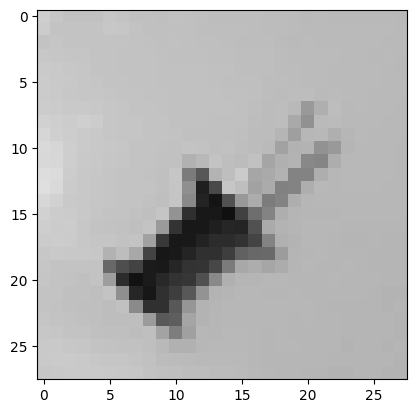

In [14]:
### Reshape image

# Convert features to 2D Numpy array
img_reshape = np.reshape(np.array(img), (height, width))

# Show the ground-truth label
print("Actual label:", labels[true_idx])

# Display image (make sure we're looking at the right thing)
plt.imshow(img_reshape, cmap='gray', vmin=0.0, vmax=1.0)

In [15]:
### The Keras model expects images in a 4D array with dimensions (sample, height, width, channel)

# Add extra dimension to the image (placeholder for color channels)
img_0 = img_reshape.reshape(img_reshape.shape + (1,))

# Keras expects more than one image (in Numpy array), so convert image(s) to such array
images = np.array([img_0])

# Print dimensions of inference input
print(images.shape)

(1, 28, 28, 1)


In [16]:
### Do a forward pass (inference) with the test image and print the predicted probabilities

# Inference
preds = model.predict(images)

# Print out predictions
for i, pred in enumerate(preds[0]):
  print(labels[i] + ": " + str(pred))

1/1 [==============================] - 0s 73ms/step
background: 0.0003245533
bud: 0.12274976
pin: 0.80504984
sdcard: 0.07187586


In [17]:
### For either algorithm, we need to remove the Softmax activation function of the last layer
model.layers[-1].activation = None

## Saliency Map

In [18]:
### Based on: https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
def get_saliency_map(img_array, model, class_idx):

  # Gradient calculation requires input to be a tensor
  img_tensor = tf.convert_to_tensor(img_array)

  # Do a forward pass of model with image and track the computations on the "tape"
  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:

    # Compute (non-softmax) outputs of model with given image
    tape.watch(img_tensor)
    outputs = model(img_tensor, training=False)

    # Get score (predicted value) of actual class
    score = outputs[:, true_idx]

  # Compute gradients of the loss with respect to the input image
  grads = tape.gradient(score, img_tensor)

  # Finds max value in each color channel of the gradient (should be grayscale for this demo)
  grads_disp = [np.max(g, axis=-1) for g in grads]

  # There should be only one gradient heatmap for this demo
  grad_disp = grads_disp[0]

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  grad_disp = tf.abs(grad_disp)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(grad_disp)
  heatmap_max = np.max(grad_disp)
  heatmap = (grad_disp - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [19]:
### Generate saliency map for the given input image
saliency_map = get_saliency_map(images, model, true_idx)

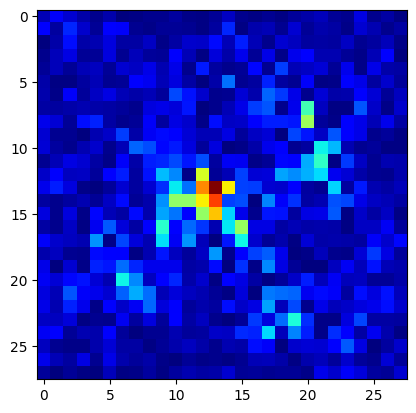

In [20]:
### Draw map
plt.imshow(saliency_map, cmap='jet', vmin=0.0, vmax=1.0)

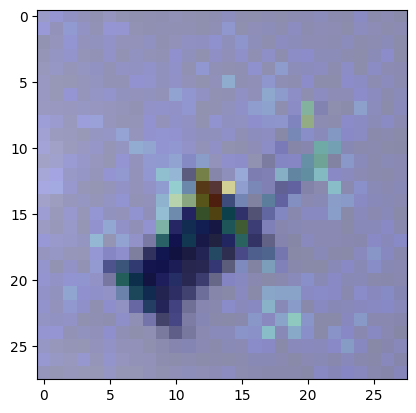

In [21]:
### Overlay the saliency map on top of the original input image
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(saliency_map, cmap='jet', alpha=0.25)

## Grad-CAM

In [22]:
### This function comes from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  heatmap = tf.abs(heatmap)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)
  heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [23]:
### We need to tell Grad-CAM where to find the last convolution layer

# Print out the layers in the model
for layer in model.layers:
  print(layer, layer.name)

# Go backwards through the model to find the last convolution layer
last_conv_layer = None
for layer in reversed(model.layers):
    if 'conv' in layer.name:
        last_conv_layer = layer.name
        break

# Give a warning if the last convolution layer could not be found
if last_conv_layer is not None:
  print("Last convolution layer found:", last_conv_layer)
else:
  print("ERROR: Last convolution layer could not be found. Do not continue.")

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7eaec8653340> conv2d
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7eaec8652170> max_pooling2d
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7eaec8651c00> conv2d_1
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7eaec853c580> max_pooling2d_1
<keras.src.layers.reshaping.flatten.Flatten object at 0x7eaec853f0a0> flatten
<keras.src.layers.regularization.dropout.Dropout object at 0x7eaec853f1c0> dropout
<keras.src.layers.core.dense.Dense object at 0x7eaec853d150> y_pred
Last convolution layer found: conv2d_1


In [24]:
### Generate class activation heatmap
heatmap = make_gradcam_heatmap(images, model, last_conv_layer)

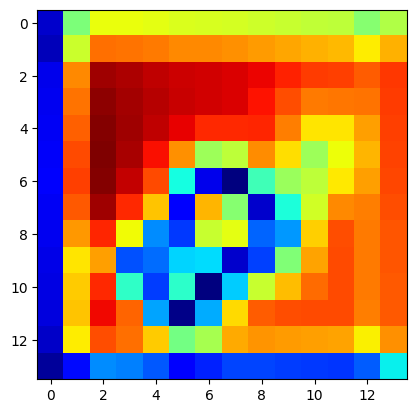

In [25]:
### Draw map
plt.imshow(heatmap, cmap='jet', vmin=0.0, vmax=1.0)

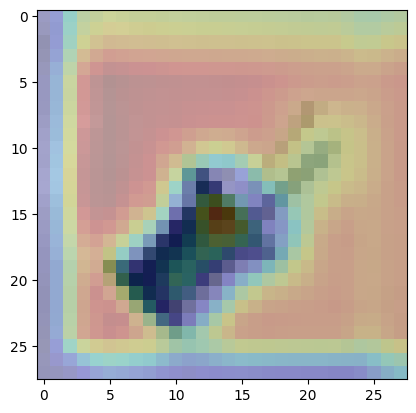

In [26]:
### Overlay the saliency map on top of the original input image

# The heatmap is a lot smaller than the original image, so we upsample it
big_heatmap = cv2.resize(heatmap, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

# Draw original image with heatmap superimposed over it
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(big_heatmap, cmap='jet', alpha=0.25)